In [1]:
import pandas as pd
import numpy as np
import re
import os
from pathlib import Path

In [2]:
parent= Path(os.getcwd()).parent
filepath= Path(r'data\raw\marketing_campaign.csv')
path= parent / filepath

df= pd.read_csv(path, delimiter= '\t')

df.sample(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
1156,967,1976,Graduation,Married,46049.0,1,1,21-07-2013,11,342,...,7,0,0,0,0,0,0,3,11,1
2078,5079,1971,Graduation,Married,NaN,1,1,03-03-2013,82,71,...,8,0,0,0,0,0,0,3,11,0
1717,7629,1977,Graduation,Married,22108.0,1,1,08-05-2014,46,5,...,7,0,0,0,0,0,0,3,11,0
1986,10821,1978,Graduation,Married,57113.0,1,1,06-02-2013,45,182,...,7,0,0,0,0,0,0,3,11,0
1083,9523,1982,Graduation,Together,40479.0,1,0,17-08-2013,95,5,...,4,0,0,0,0,0,0,3,11,0


In [3]:
def is_parent(df):
    is_parent= np.where(
        (df['kidhome'] > 0) | (df['teenhome'] > 0),
        1, 0
    )
    return is_parent

<AxesSubplot:>

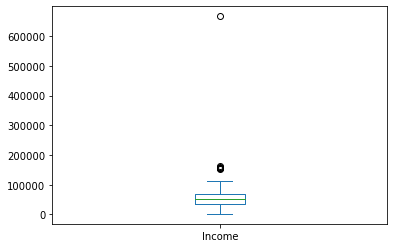

In [4]:
df['Income'].plot(kind= 'box')

In [5]:
df_clean= (df
    .rename(columns= lambda c: re.sub("([a-z])([A-Z])","\g<1> \g<2>",c).lower().replace(' ', '_'))
    .rename(columns= {'response': 'accepted_cmp6'})
    .drop_duplicates(subset= 'id', keep= 'first')
    .loc[lambda df_: df_['income'] < 600_000]
    .assign(
        dt_customer= lambda df_: pd.to_datetime(df_['dt_customer'], format= '%d-%m-%Y'),
        education= lambda df_: df_['education'].replace({
            'Graduation': 'Graduate',
            'PhD': 'Postgraduate',
            'Master': 'Postgraduate',
            '2n Cycle': 'Postgraduate',
            'Basic': 'Undergraduate'
        }).astype(pd.CategoricalDtype(['Undergraduate', 'Graduate', 'Postgraduate'], ordered= True)),
        marital_status= lambda df_: df_['marital_status'].replace({
            'Married': 'Together', 
            'Single': 'Alone', 
            'Divorced': 'Alone', 
            'Widow': 'Alone', 
            'Absurd': 'Unspecified',
            'YOLO': 'Unspecified',
        }),
        income= lambda df_: df_['income'].fillna(0)
    )
    .assign(
        age= lambda df_: df_['dt_customer'].max().year - df_['year_birth'],
        is_parent= lambda df_: is_parent(df_),
        dt_customer_day= lambda df_: df_['dt_customer'].dt.day,
        dt_customer_dow= lambda df_: df_['dt_customer'].dt.day_of_week,
        dt_customer_wom= lambda df_: np.ceil(df_['dt_customer'].dt.day / 7),
        dt_customer_month= lambda df_: df_['dt_customer'].dt.month,
        dt_customer_year= lambda df_: df_['dt_customer'].dt.year,
        total_spent= lambda df_: df_.loc[:, df_.columns.str.contains('mnt')].sum(axis= 1),
        total_purchase= lambda df_: df_.loc[:, df_.columns.str.contains('web_purchase|catalog_purchase|store_purchase', regex= True)]
            .sum(axis= 1),
    )
    .astype({
        'id': 'int', 
        'education': 'category',
        'marital_status': 'category',
        'income': 'int',
        'kidhome': 'int',
        'teenhome': 'int',
        'recency': 'int',
        'age': 'int',
        'dt_customer_wom': 'int'
    })
    .drop(columns= ['z_cost_contact', 'z_revenue', 'year_birth'])
    [[
        'id', 'age', 'education', 'marital_status', 'income', 
        'is_parent', 'kidhome','teenhome', 
        'dt_customer', 'dt_customer_day', 'dt_customer_dow', 'dt_customer_wom', 'dt_customer_month', 'dt_customer_year', 
        'recency', 
        'mnt_wines', 'mnt_fruits', 'mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products', 'mnt_gold_prods', 'total_spent',
        'num_web_purchases', 'num_catalog_purchases', 'num_store_purchases', 'total_purchase',
        'num_web_visits_month',
        'accepted_cmp1', 'accepted_cmp2', 'accepted_cmp3', 'accepted_cmp4', 'accepted_cmp5', 'accepted_cmp6', 'num_deals_purchases', 
        'complain'
    ]]
)

In [6]:
df_clean.sample(5)

,id,age,education,marital_status,income,is_parent,kidhome,teenhome,dt_customer,dt_customer_day,...,total_purchase,num_web_visits_month,accepted_cmp1,accepted_cmp2,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp6,num_deals_purchases,complain
2155,8933,31,Postgraduate,Together,32146,1,1,0,2014-05-12,12,...,6,6,0,0,0,0,0,0,2,0
1240,11086,30,Undergraduate,Alone,25707,1,1,0,2014-01-18,18,...,4,7,0,0,0,0,0,0,1,0
702,6384,36,Graduate,Alone,71022,1,0,1,2014-02-11,11,...,18,8,0,0,1,0,0,0,3,0
461,7851,65,Graduate,Alone,70165,0,0,0,2013-09-22,22,...,21,1,0,0,0,0,0,0,1,0
2177,492,41,Postgraduate,Unspecified,48432,1,0,1,2012-10-18,18,...,14,8,0,0,0,0,0,0,5,0


In [9]:
parent= Path(os.getcwd()).parent
filepath= Path('data/clean/clean_data.parquet')
path= parent / filepath

if not os.path.exists(path):
    df_clean.to_parquet(path, index= False)
    print('File saved.')
else:
    print('File already exist.')

File saved.
